In [1]:
# Import Dependencies
import yaml
from joblib import dump, load
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Naive Bayes Approach
from sklearn.naive_bayes import MultinomialNB
# Trees Approach
from sklearn.tree import DecisionTreeClassifier
# Ensemble Approach
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import io
from PIL import Image

In [2]:
class DiseasePrediction:
    # Initialize and Load the Config File
    def __init__(self, model_name=None):
        # Load Config File
        try:
            with open('./config.yaml', 'r') as f:
                self.config = yaml.safe_load(f)
        except Exception as e:
            print("Error reading Config file...")

        # Verbose
        self.verbose = self.config['verbose']
        # Load Training Data
        self.train_features, self.train_labels, self.train_df = self._load_train_dataset()
        # Load Test Data
        self.test_features, self.test_labels, self.test_df = self._load_test_dataset()
        # Feature Correlation in Training Data
        self._feature_correlation(data_frame=self.train_df, show_fig=False)
        # Model Definition
        self.model_name = model_name
        # Model Save Path
        self.model_save_path = self.config['model_save_path']

    # Function to Load Train Dataset
    def _load_train_dataset(self):
        df_train = pd.read_csv(self.config['dataset']['training_data_path'])
        cols = df_train.columns
        cols = cols[:-2]
        train_features = df_train[cols]
        train_labels = df_train['prognosis']

        # Check for data sanity
        assert (len(train_features.iloc[0]) == 132)
        assert (len(train_labels) == train_features.shape[0])

        if self.verbose:
            print("Length of Training Data: ", df_train.shape)
            print("Training Features: ", train_features.shape)
            print("Training Labels: ", train_labels.shape)
        return train_features, train_labels, df_train

    # Function to Load Test Dataset
    def _load_test_dataset(self):
        df_test = pd.read_csv(self.config['dataset']['test_data_path'])
        cols = df_test.columns
        cols = cols[:-1]
        test_features = df_test[cols]
        test_labels = df_test['prognosis']

        # Check for data sanity
        assert (len(test_features.iloc[0]) == 132)
        assert (len(test_labels) == test_features.shape[0])

        if self.verbose:
            print("Length of Test Data: ", df_test.shape)
            print("Test Features: ", test_features.shape)
            print("Test Labels: ", test_labels.shape)
        return test_features, test_labels, df_test

    # Features Correlation
    def _feature_correlation(self, data_frame=None, show_fig=False):
        # Get Feature Correlation
        corr = data_frame.corr()
        '''sn.heatmap(corr, square=True, annot=False, cmap="YlGnBu")
        plt.title("Feature Correlation")
        plt.tight_layout()
        if show_fig:
            plt.show()
        plt.savefig('feature_correlation.png')'''

    # Dataset Train Validation Split
    def _train_val_split(self):
        X_train, X_val, y_train, y_val = train_test_split(self.train_features, self.train_labels,
                                                          test_size=self.config['dataset']['validation_size'],
                                                          random_state=self.config['random_state'])

        if self.verbose:
            print("Number of Training Features: {0}\tNumber of Training Labels: {1}".format(len(X_train), len(y_train)))
            print("Number of Validation Features: {0}\tNumber of Validation Labels: {1}".format(len(X_val), len(y_val)))
        return X_train, y_train, X_val, y_val

    # Model Selection
    def select_model(self):
        if self.model_name == 'mnb':
            self.clf = MultinomialNB()
        elif self.model_name == 'decision_tree':
            self.clf = DecisionTreeClassifier(criterion=self.config['model']['decision_tree']['criterion'])
        elif self.model_name == 'random_forest':
            self.clf = RandomForestClassifier(n_estimators=self.config['model']['random_forest']['n_estimators'])
        elif self.model_name == 'gradient_boost':
            self.clf = GradientBoostingClassifier(n_estimators=self.config['model']['gradient_boost']['n_estimators'],
                                                  criterion=self.config['model']['gradient_boost']['criterion'])
        return self.clf

    # ML Model
    def train_model(self):
        # Get the Data
        X_train, y_train, X_val, y_val = self._train_val_split()
        classifier = self.select_model()
        # Training the Model
        classifier = classifier.fit(X_train, y_train)
        # Trained Model Evaluation on Validation Dataset
        confidence = classifier.score(X_val, y_val)
        # Validation Data Prediction
        y_pred = classifier.predict(X_val)
        # Model Validation Accuracy
        accuracy = accuracy_score(y_val, y_pred)
        # Model Confusion Matrix
        conf_mat = confusion_matrix(y_val, y_pred)
        # Model Classification Report
        clf_report = classification_report(y_val, y_pred)
        # Model Cross Validation Score
        score = cross_val_score(classifier, X_val, y_val, cv=3)

        if self.verbose:
            print('\nTraining Accuracy: ', confidence)
            print('\nValidation Prediction: ', y_pred)
            print('\nValidation Accuracy: ', accuracy)
            print('\nValidation Confusion Matrix: \n', conf_mat)
            print('\nCross Validation Score: \n', score)
            print('\nClassification Report: \n', clf_report)

        # Save Trained Model
        dump(classifier, str(self.model_save_path + self.model_name + ".joblib"))

    # Function to Make Predictions on Test Data
    def make_prediction(self, saved_model_name=None, test_data=None):
        try:
            # Load Trained Model
            clf = load(str(self.model_save_path + saved_model_name + ".joblib"))
        except Exception as e:
            print("Model not found...")

        if test_data is not None:
            result = clf.predict(test_data)
            return result
        else:
            result = clf.predict(self.test_features)
        accuracy = accuracy_score(self.test_labels, result)
        clf_report = classification_report(self.test_labels, result)
        return accuracy, clf_report

In [10]:
# Model Currently Training
current_model_name = 'mnb'
# Instantiate the Class
dp = DiseasePrediction(model_name=current_model_name)
# Train the Model
dp.train_model()
# Get Model Performance on Test Data
test_accuracy_mnb, classification_report_mnb = dp.make_prediction(saved_model_name=current_model_name)
print("Model Test Accuracy for NB: ", test_accuracy_mnb)
print("Test Data Classification Report for NB: \n", classification_report_mnb)

Length of Training Data:  (4920, 134)
Training Features:  (4920, 132)
Training Labels:  (4920,)
Length of Test Data:  (42, 133)
Test Features:  (42, 132)
Test Labels:  (42,)


C:\Users\Kshitija\AppData\Local\Temp\ipykernel_6708\1727605150.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_frame.corr()


Number of Training Features: 3296	Number of Training Labels: 3296
Number of Validation Features: 1624	Number of Validation Labels: 1624

Training Accuracy:  1.0

Validation Prediction:  ['Osteoarthristis' 'Allergy' 'Alcoholic hepatitis' ...
 'Dimorphic hemmorhoids(piles)' 'GERD' 'Pneumonia']

Validation Accuracy:  1.0

Validation Confusion Matrix: 
 [[47  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 39  0]
 [ 0  0  0 ...  0  0 44]]

Cross Validation Score: 
 [1. 1. 1.]

Classification Report: 
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        47
                                   AIDS       1.00      1.00      1.00        50
                                   Acne       1.00      1.00      1.00        41
                    Alcoholic hepatitis       1.00      1.00      1.00        40
                      

In [13]:
# Model Currently Training
current_model_name = 'decision_tree'
# Instantiate the Class
dp = DiseasePrediction(model_name=current_model_name)
# train the Model
dp.train_model()
# Get Model Performance on Test Data
test_accuracy_dt, classification_report_dt = dp.make_prediction(saved_model_name=current_model_name)
print("Model Test Accuracy for DT: ", test_accuracy_dt)
print("Test Data Classification Report for DT: \n", classification_report_dt)

Length of Training Data:  (4920, 134)
Training Features:  (4920, 132)
Training Labels:  (4920,)
Length of Test Data:  (42, 133)
Test Features:  (42, 132)
Test Labels:  (42,)


C:\Users\Kshitija\AppData\Local\Temp\ipykernel_6708\1727605150.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_frame.corr()


Number of Training Features: 3296	Number of Training Labels: 3296
Number of Validation Features: 1624	Number of Validation Labels: 1624

Training Accuracy:  1.0

Validation Prediction:  ['Osteoarthristis' 'Allergy' 'Alcoholic hepatitis' ...
 'Dimorphic hemmorhoids(piles)' 'GERD' 'Pneumonia']

Validation Accuracy:  1.0

Validation Confusion Matrix: 
 [[47  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 39  0]
 [ 0  0  0 ...  0  0 44]]

Cross Validation Score: 
 [0.97232472 0.92791128 0.96118299]

Classification Report: 
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        47
                                   AIDS       1.00      1.00      1.00        50
                                   Acne       1.00      1.00      1.00        41
                    Alcoholic hepatitis       1.00      1.00      1.00        4

In [12]:
# Model Currently Training
current_model_name = 'random_forest'
# Instantiate the Class
dp = DiseasePrediction(model_name=current_model_name)
# Train the Model
dp.train_model()
# Get Model Performance on Test Data
test_accuracy_rf, classification_report_rf = dp.make_prediction(saved_model_name=current_model_name)
print("Model Test Accuracy for RF: ", test_accuracy_rf)
print("Test Data Classification Report for RF: \n", classification_report_rf)

Length of Training Data:  (4920, 134)
Training Features:  (4920, 132)
Training Labels:  (4920,)
Length of Test Data:  (42, 133)
Test Features:  (42, 132)
Test Labels:  (42,)


C:\Users\Kshitija\AppData\Local\Temp\ipykernel_6708\1727605150.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_frame.corr()


Number of Training Features: 3296	Number of Training Labels: 3296
Number of Validation Features: 1624	Number of Validation Labels: 1624

Training Accuracy:  1.0

Validation Prediction:  ['Osteoarthristis' 'Allergy' 'Alcoholic hepatitis' ...
 'Dimorphic hemmorhoids(piles)' 'GERD' 'Pneumonia']

Validation Accuracy:  1.0

Validation Confusion Matrix: 
 [[47  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 39  0]
 [ 0  0  0 ...  0  0 44]]

Cross Validation Score: 
 [0.99446494 0.99630314 1.        ]

Classification Report: 
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        47
                                   AIDS       1.00      1.00      1.00        50
                                   Acne       1.00      1.00      1.00        41
                    Alcoholic hepatitis       1.00      1.00      1.00        4

In [14]:
# Model Currently Training
current_model_name = 'gradient_boost'
# Instantiate the Class
dp = DiseasePrediction(model_name=current_model_name)
# Train the Model
dp.train_model()
# Get Model Performance on Test Data
test_accuracy_gb, classification_report_gb = dp.make_prediction(saved_model_name=current_model_name)
print("Model Test Accuracy for GB: ", test_accuracy_gb)
print("Test Data Classification Report for GB: \n", classification_report_gb)

Length of Training Data:  (4920, 134)
Training Features:  (4920, 132)
Training Labels:  (4920,)
Length of Test Data:  (42, 133)
Test Features:  (42, 132)
Test Labels:  (42,)


C:\Users\Kshitija\AppData\Local\Temp\ipykernel_6708\1727605150.py:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_frame.corr()


Number of Training Features: 3296	Number of Training Labels: 3296
Number of Validation Features: 1624	Number of Validation Labels: 1624

Training Accuracy:  1.0

Validation Prediction:  ['Osteoarthristis' 'Allergy' 'Alcoholic hepatitis' ...
 'Dimorphic hemmorhoids(piles)' 'GERD' 'Pneumonia']

Validation Accuracy:  1.0

Validation Confusion Matrix: 
 [[47  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 39  0]
 [ 0  0  0 ...  0  0 44]]

Cross Validation Score: 
 [0.98523985 0.98151571 0.99445471]

Classification Report: 
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        47
                                   AIDS       1.00      1.00      1.00        50
                                   Acne       1.00      1.00      1.00        41
                    Alcoholic hepatitis       1.00      1.00      1.00        4

0

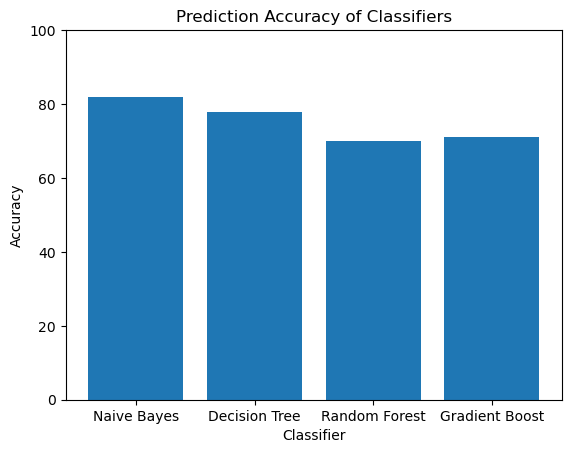

In [21]:
# Plot bar chart
classifiers = ['Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boost']
accuracies = [82, 77.87, 70, 71]
    
# Convert accuracies to percentages
max_accuracy = 100
accuracies_percentages = [(accuracy / max_accuracy) * 100 for accuracy in accuracies]
    
plt1.bar(classifiers, accuracies_percentages)
plt1.ylim(0, 100)  # Set y-axis limit to 0-1 for accuracy range
plt1.xlabel('Classifier')
plt1.ylabel('Accuracy')
plt1.title('Prediction Accuracy of Classifiers')
plt1.grid(False)

# Save the plot to a BytesIO object
img = io.BytesIO()
plt1.savefig(img, format='png')
img.seek(0)